In [1]:
import sys
from gravipy.tensorial import * 
import sympy as sym
import scipy
from sympy import init_printing
import inspect
init_printing()
import numpy as np
import math
import seaborn as sns
#sns.set('talk')
from scipy.integrate import solve_ivp

import scipy.integrate
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# define some symbolic variables
t, r, theta, phi, M = symbols('t, r, \\theta, \phi, M')

# create a coordinate four-vector object instantiating 
# the Coordinates class
x = Coordinates('x', [t, r, theta, phi])

# define a matrix of a metric tensor components
Metric = diag((1-2*M/r), -1/(1-2*M/r), -r**2, -r**2*sin(theta)**2)
#Metric = diag(A, -B, -r**2, -r**2*sin(theta)**2)

# create a metric tensor object instantiating the MetricTensor class
g = MetricTensor('g', x, Metric)

In [3]:
tau = Symbol('\\tau')
w = Geodesic('w', g, tau)
w(All).transpose()

⎡                                                                        d    
⎢                                                                  2⋅M⋅─────(r
⎢                                                                      d\tau  
⎢                                                                  ───────────
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                            2                        2       
⎢                            ⎛  d           ⎞         ⎛  d           ⎞        
⎢                          M⋅⎜─────(t(\tau))⎟       M⋅⎜─────(r(\tau))⎟        
⎢                            ⎝d\tau         ⎠         ⎝d\tau         ⎠        
⎢                        - ─────────────────── + ───

Wir lassen nur ebene Bewegungen zu ($\theta=\frac{\pi}{2}, \frac{d \theta}{d\tau}=0, \frac{d^2 \theta}{d\tau^2}=0$).

In [4]:
DGL = w(All).subs([(x(-3).diff(tau,tau),0),
                   (x(-3).diff(tau),0),
                   (x(-3),math.pi/2)]).transpose()
DGL

⎡                       d              d                                      
⎢                 2⋅M⋅─────(r(\tau))⋅─────(t(\tau))                      2    
⎢                     d\tau          d\tau            ⎛    2⋅M      ⎞   d     
⎢                 ───────────────────────────────── + ⎜- ─────── + 1⎟⋅──────(t
⎢                               2                     ⎝  r(\tau)    ⎠      2  
⎢                              r (\tau)                               d\tau   
⎢                                                                             
⎢                                                                             
⎢                    2                        2                               
⎢    ⎛  d           ⎞         ⎛  d           ⎞                                
⎢  M⋅⎜─────(t(\tau))⎟       M⋅⎜─────(r(\tau))⎟                                
⎢    ⎝d\tau         ⎠         ⎝d\tau         ⎠                   ⎛  d         
⎢- ─────────────────── + ───────────────────────── +

# Radial in schwarzes Loch einfallender Probekörper

Zusätzlich kann man sich auf den radial in das schwarze Loch einfallenden Probekörper beschränken ($\frac{d \phi}{d\tau}=0, \frac{d^2 \phi}{d\tau^2}=0$).

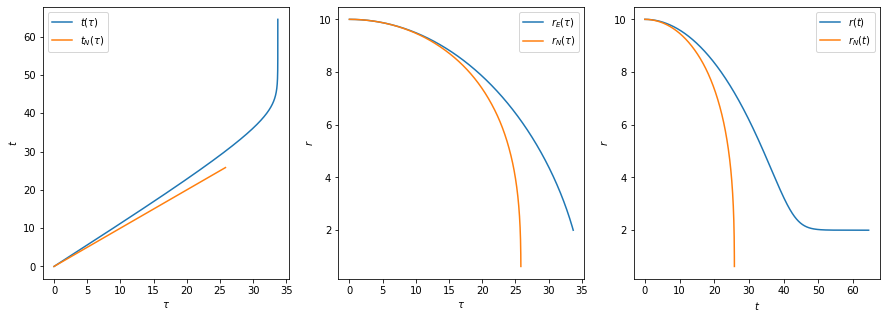

In [5]:
DGL1 = DGL.subs([(x(-4).diff(tau,tau),0),(x(-4).diff(tau),0)])
DGL1a = sym.solve(DGL1[0], x(-1).diff(tau,tau))[0]
DGL1b = sym.solve(DGL1[1], x(-2).diff(tau, tau))[0]

y = symbols('y1, y2, y3, y4')
sym_m = symbols('M')
y1, y2, y3, y4 = y
substitutes = [(x(-1).diff(tau), y3), # y3 = dt/dtau
               (x(-2).diff(tau), y4), # y4 = dr/dtau
               (x(-1), y1), # y1 = t
               (x(-2), y2), # y2 = r
               (sym_m, 1), # M = 1
              ]

DGL1a_umgeschrieben = DGL1a.subs(substitutes)
DGL1b_umgeschrieben = DGL1b.subs(substitutes)

DGL1a_neu = sym.lambdify([tau, y], DGL1a_umgeschrieben, modules=sym)
DGL1b_neu = sym.lambdify([tau, y], DGL1b_umgeschrieben, modules=sym)
DGLy3 = sym.lambdify([tau, y], y3, modules=sym)
DGLy4 = sym.lambdify([tau, y], y4, modules=sym)

def GeodaetenDGL(tau, y):
    dy1 = DGLy3(tau, y)
    dy2 = DGLy4(tau, y)
    dy3 = DGL1a_neu(tau, y)
    dy4 = DGL1b_neu(tau, y)
    return np.array([dy1, dy2, dy3, dy4])

r0 = 10
constraint = np.array([0, r0, 1/np.sqrt(1-2/r0), 0], dtype=np.float64)
t = np.linspace(0, 33.7007, 10000)

solution = scipy.integrate.solve_ivp(GeodaetenDGL, (0,33.7007), 
                                     constraint, t_eval=t)
newton = lambda t, r: -t/r**2
solution_newton = scipy.integrate.solve_ivp(newton, (0,33.7007), 
                                            np.array([r0]), t_eval=t)

fig, axes = plt.subplots(1,3, figsize=(15,5))
ax1, ax2, ax3 = axes
ax1.plot(solution['t'], solution['y'][0,:], '-', label='$t(\\tau)$')
ax1.plot(solution_newton['t'], solution_newton['t'], '-', label='$t_N(\\tau)$')
ax2.plot(solution['t'], solution['y'][1,:], '-', label='$r_E(\\tau)$')
ax2.plot(solution_newton['t'], solution_newton['y'][0,:], '-', label='$r_N(\\tau)$')
ax3.plot(solution['y'][0, :], solution['y'][1,:], '-', label='$r(t)$')
ax3.plot(solution_newton['t'], solution_newton['y'][0,:], '-', label='$r_N(t)$')

for ax in [ax1, ax2]:
    ax.set_xlabel('$\\tau$')
for ax in [ax2, ax3]:
    ax.set_ylabel('$r$')
ax1.set_ylabel('$t$')
ax3.set_xlabel('$t$')

for ax in axes:
    ax.legend()
plt.show()

# Bewegung um schwarzes Loch in der Ebene

In [6]:
DGL

⎡                       d              d                                      
⎢                 2⋅M⋅─────(r(\tau))⋅─────(t(\tau))                      2    
⎢                     d\tau          d\tau            ⎛    2⋅M      ⎞   d     
⎢                 ───────────────────────────────── + ⎜- ─────── + 1⎟⋅──────(t
⎢                               2                     ⎝  r(\tau)    ⎠      2  
⎢                              r (\tau)                               d\tau   
⎢                                                                             
⎢                                                                             
⎢                    2                        2                               
⎢    ⎛  d           ⎞         ⎛  d           ⎞                                
⎢  M⋅⎜─────(t(\tau))⎟       M⋅⎜─────(r(\tau))⎟                                
⎢    ⎝d\tau         ⎠         ⎝d\tau         ⎠                   ⎛  d         
⎢- ─────────────────── + ───────────────────────── +

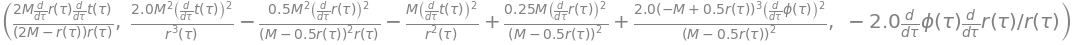

In [7]:
DGLa = sym.solve(DGL[0], x(-1).diff(tau,tau))[0]
DGLb = sym.solve(DGL[1], x(-2).diff(tau, tau))[0]
DGLd = sym.solve(DGL[3], x(-4).diff(tau, tau))[0]
DGLa, DGLb, DGLd

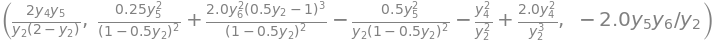

In [8]:
y = symbols('y1, y2, y3, y4, y5, y6')
sym_m = symbols('M')
y1, y2, y3, y4, y5, y6 = y
substitutes = [
               (x(-1).diff(tau), y4), # y4 = dt/dtau
               (x(-2).diff(tau), y5), # y5 = dr/dtau
               (x(-4).diff(tau), y6), # y6 = dφ/dtau
               (x(-1), y1), # y1 = t
               (x(-2), y2), # y2 = r
               (x(-4), y3), # y3 = φ
               (sym_m, 1), # M = 1
              ]

DGLa_umgeschrieben = DGLa.subs(substitutes)
DGLb_umgeschrieben = DGLb.subs(substitutes)
DGLd_umgeschrieben = DGLd.subs(substitutes)
(DGLa_umgeschrieben, DGLb_umgeschrieben, DGLd_umgeschrieben)

In [9]:
DGLa_neu = sym.lambdify([tau, y], DGLa_umgeschrieben, modules=sym)
DGLb_neu = sym.lambdify([tau, y], DGLb_umgeschrieben, modules=sym)
DGLd_neu = sym.lambdify([tau, y], DGLd_umgeschrieben, modules=sym)
DGLy4 = sym.lambdify([tau, y], y4, modules=sym)
DGLy5 = sym.lambdify([tau, y], y5, modules=sym)
DGLy6 = sym.lambdify([tau, y], y6, modules=sym)

def EbeneDGL(tau, y):
    dy1 = DGLy4(tau, y)
    dy2 = DGLy5(tau, y)
    dy3 = DGLy6(tau, y)
    dy4 = DGLa_neu(tau, y)
    dy5 = DGLb_neu(tau, y)
    dy6 = DGLd_neu(tau, y)
    return np.array([dy1, dy2, dy3, dy4, dy5, dy6])

In [10]:
l0 = 4.47
r0 = 9
t0 = 0
phi0 = 0
dr0 = 0.0
dphi0 = l0/r0**2
dt0 = 1/np.sqrt(1-2/r0)*np.sqrt(1+r0**2*dphi0**2)

constraint = np.array([t0, r0, phi0,
                       dt0, dr0, dphi0])
tend = 800
t = np.linspace(0, tend, 1001)
solution = scipy.integrate.solve_ivp(EbeneDGL, (0, tend), 
                                     constraint, t_eval=t)
solution

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 86
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([  0. ,   0.8,   1.6, ..., 798.4, 799.2, 800. ])
 t_events: None
        y: array([[ 0.00000000e+00,  1.01281615e+00,  2.02551056e+00, ...,
         8.36725397e+02,  8.37547823e+02,  8.38370281e+02],
       [ 9.00000000e+00,  9.00189632e+00,  9.00758244e+00, ...,
         4.77232510e+01,  4.76810823e+01,  4.76387415e+01],
       [ 0.00000000e+00,  4.41419478e-02,  8.82467569e-02, ...,
         4.38255954e+00,  4.38412000e+00,  4.38568313e+00],
       [ 1.26604559e+00,  1.26596939e+00,  1.26574116e+00, ...,
         1.02801175e+00,  1.02805153e+00,  1.02809154e+00],
       [ 0.00000000e+00,  4.74022001e-03,  9.47337802e-03, ...,
        -5.26014740e-02, -5.28173508e-02, -5.30334989e-02],
       [ 5.51851852e-02,  5.51619372e-02,  5.50923131e-02, ...,
         1.94866716e-03,  1.95211689e-03,  1.95558895e-0

In [11]:
VeffRez = lambda r,M,l: np.sqrt(1-2*M/r)*np.sqrt(1+l**2/r**2)
VeffFb = lambda r,M,l: -(M/r) + ((l**2)/(2*r**2)) - ((M*l**2)/(r**3))

In [12]:
#r0 = 10
#t0=0
#phi0=0
#theta0=np.pi/2
#dr0=0
#dphi0=0.041
#dt0=(1/np.sqrt(1-2/r0)*np.sqrt(1+r0**2*dphi0**2))
#dtheta0=0
#l = r0**2*dphi0
#r_span = np.linspace(4,35, 1000)
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,9))
#ax1.plot(r_span, VeffRez(r_span, 1, l), 'b-')
#ax1.set_title('$V_{eff}^{Rez} = \\sqrt{1-\\frac{2M}{r}}\\cdot \\sqrt{1+\\frac{l^2}{r^2}}$')
#ax1.plot([r0], [VeffRez(r0, 1, l)], 'ro')
#ax2.plot(r_span, VeffFb(r_span, 1, l), 'g-')
#ax2.set_title('$V_{eff}^{Fb} = −\\frac{M\\cdot l^2}{r^3} ​ −\\frac{M}{r} ​+ \\frac{l^2}{2r^2}​$')
#ax2.plot([r0], [VeffFb(r0, 1, l)], 'ro')

In [13]:
from ipywidgets import interact
import ipywidgets as widgets

@interact(potential1 = True,r_0=widgets.FloatSlider(min=0, max=20, step=0.5, value=10), M=widgets.FloatSlider(min=0, max=30, step=1, value=1), l_0=widgets.FloatSlider(min=0, max=5, step=0.001, value=0.041))
def VeffRez(potential1,r_0,M,l_0):
    Veff = lambda r,M,l: np.sqrt(1-2*M/r)*np.sqrt(1+l**2/r**2)
    if not potential1:
        Veff = lambda r,M,l: -(M/r) + ((l**2)/(2*r**2)) - ((M*l**2)/(r**3))
    dphi0 = l_0/r0**2
    #l = r0**2*dphi0
    r_span = np.linspace(4,35, 1000)
    #y = np.sqrt(1-2*M/r_span)*np.sqrt(1+l**2/r_span**2)
    y = Veff(r_span,M,l_0)
    plt.plot(r_span, y)
    #x = np.sqrt(1-2*M/r0)*np.sqrt(1+l**2/r0**2)
    x = Veff(r_0,M,l_0)
    plt.title('$V_{eff}^{Rez} = \\sqrt{1-\\frac{2M}{r}}\\cdot \\sqrt{1+\\frac{l^2}{r^2}}$')
    if not potential1:
        plt.title('$V_{eff}^{Fb} = −\\frac{M\\cdot l^2}{r^3} ​ −\\frac{M}{r} ​+ \\frac{l^2}{2r^2}​$')
    plt.plot(r_0, x, 'ro')
    plt.xlabel("r")
    plt.ylabel('$V_{eff}$')
    #return  r_0,l_0

interactive(children=(Checkbox(value=True, description='potential1'), FloatSlider(value=10.0, description='r_0…

In [14]:
l0 = 4.47
r0 = 9
#l0 = 2*np.sqrt(3)
#r0 = 6


t0 = 0
phi0 = 0
dr0 = 0.0
dphi0 = l0/r0**2
dt0 = 1/np.sqrt(1-2/r0)*np.sqrt(1+r0**2*dphi0**2)

constraint = np.array([t0, r0, phi0,
                       dt0, dr0, dphi0])
tend = 3000
t = np.linspace(0, tend, 1001)
solution = scipy.integrate.solve_ivp(EbeneDGL, (0, tend), 
                                     constraint, t_eval=t)

In [15]:
r1 = solution['y'][1,:]
phi1 = solution['y'][2,:]
x = r1*np.cos(phi1)
y = r1*np.sin(phi1)
xx = r1*np.cos(phi1)
yy = r1*np.sin(phi1)

xm = np.min(x) - 1.5
xM = np.max(x) + 1.5
ym = np.min(y) - 1.5
yM = np.max(y) + 1.5

In [16]:
#import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
#from plotly.graph_objs import *

#init_notebook_mode(connected=True)  
#import numpy as np
#
#r1 = solution['y'][1,:]
#phi1 = solution['y'][2,:]
#x = r1*np.cos(phi1)
#y = r1*np.sin(phi1)
#xx = r1*np.cos(phi1)
#yy = r1*np.sin(phi1)
#
#xm = np.min(x) - 1.5
#xM = np.max(x) + 1.5
#ym = np.min(y) - 1.5
#yM = np.max(y) + 1.5
#N = 50
#
#from plotly.subplots import make_subplots
##fig = make_subplots(rows=3, cols=1)
#
#fig = go.Figure(
#    data=[go.Scatter(x=x, y=y,
#                     mode="lines",
#                     line=dict(width=2, color="blue")),
#          #go.Scatter(x=x, y=y,
#          #           mode="lines",
#          #           line=dict(width=2, color="blue"))
#         ],
#    layout=go.Layout(
#        xaxis=dict(range=[xm, xM], autorange=False, zeroline=False),
#        yaxis=dict(range=[ym, yM], autorange=False, zeroline=False),
#        title_text="Kinematic Generation of a Planar Curve", hovermode="closest",
#        updatemenus=[dict(type="buttons",
#                          buttons=[dict(label="Play",
#                                        method="animate",
#                                        args=[None]),
#                                   dict(label="Pause",
#                                        method="animate",
#                                        args=[None])])]),
#    frames=[go.Frame(
#        data=[go.Scatter(
#            x=[xx[k]],
#            y=[yy[k]],
#            mode="markers",
#            marker=dict(color="red", size=10))])
#
#        for k in range(N)]
#)
#
#fig.show()

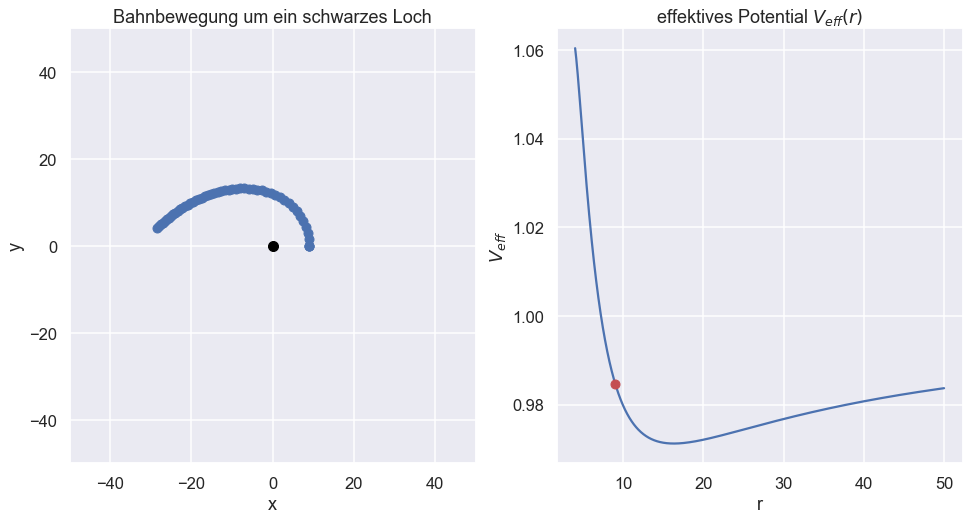

In [18]:
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
sns.set(style="ticks", context="talk")
sns.set_style("darkgrid")
plt.ioff()
plt.rcParams["animation.html"] = "jshtml"



fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,8))
ax1.set_xlim(-50,50)
ax1.set_ylim(-50,50)
ax1.set_title('Bahnbewegung um ein schwarzes Loch')
ax1.set_ylabel('y')
ax1.set_xlabel('x')

data_x = xx[::1]
data_y = yy[::1]


Veff = lambda r,M,l: np.sqrt(1-2*M/r)*np.sqrt(1+l**2/r**2)
M = 1
dphi0 = l0/r0**2
r_span = np.linspace(4,50, 1000)
y = Veff(r_span,M,l0)
ax2.set_xlim(4,50)
ax1.plot(0,0,'o', color='black',markersize=10,)

def animate(t):
    #plt.cla()
    ax1.plot(data_x[t],data_y[t],'bo')
    
    r_ = np.sqrt(data_x[t]**2+data_y[t]**2)
    ax2.cla()
    ax2.plot(r_span, y,'b')
    ax2.plot(r_, Veff(r0,M,l0),'ro')
    ax2.set_title('effektives Potential $V_{eff}(r)$')
    ax2.set_xlabel('r')
    ax2.set_ylabel('$V_{eff}$')
    if t>0:
        ax1.plot([data_x[t], data_x[t-1]], [data_y[t], data_y[t-1]],'b--')
    
matplotlib.animation.FuncAnimation(fig, animate, frames=50)